Assignment 3

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs Available:  1


(60000, 28, 28)
(60000,)
(28, 28)


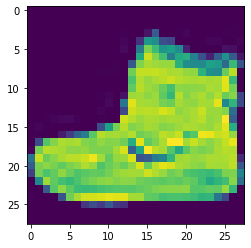

In [ ]:
mnist_fashion = tf.keras.datasets.fashion_mnist
(train_images_mf, train_labels_mf), (test_images_mf, test_labels_mf) = mnist_fashion.load_data()

print(train_images_mf.shape)
print(train_labels_mf.shape)
print(test_images_mf[0].shape)
#show the first image.
plt.imshow(train_images_mf[0])

(60000, 28, 28)
(60000,)
(28, 28)


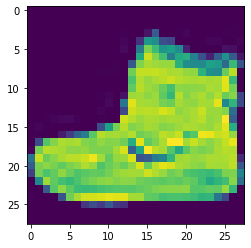

In [ ]:
mnist_fashion = tf.keras.datasets.fashion_mnist
(train_images_mf, train_labels_mf), (test_images_mf, test_labels_mf) = mnist_fashion.load_data()

print(train_images_mf.shape)
print(train_labels_mf.shape)
print(test_images_mf[0].shape)
#show the first image.
plt.imshow(train_images_mf[0])

In [ ]:
data_mf = tf.data.Dataset.from_tensor_slices(
    (train_images_mf[0:5000].reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_labels_mf[0:5000].astype(np.int32)))
data_mf = data_mf.shuffle(buffer_size=5000).batch(128).repeat()

test_data_mf = tf.data.Dataset.from_tensor_slices(
    (test_images_mf[:5000].reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_labels_mf[:5000].astype(np.int32))).batch(5000)

num_classes = 10
print(data_mf)

print(train_images_mf.shape)
print(test_labels_mf.shape)


<RepeatDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>
(60000, 28, 28)
(10000,)


In [ ]:
def Genreate_CNN_Arch(conv_layers,dense_layers,num_classes,lastlayeractivation='softmax'):
  model = Sequential()
  for idx in range(len(conv_layers)):
    layer = conv_layers[idx]
    if idx == 0:
      model.add(Conv2D(layer[0],(layer[1],layer[1]),strides=(layer[2],layer[2]),padding=layer[3],activation=layer[4],input_shape=(28,28,1)))
    else:
      model.add(Conv2D(layer[0],(layer[1],layer[1]),strides=(layer[2],layer[2]),padding=layer[3],activation=layer[4]))
    if (len(layer) > 5 ): # Maxpooling 
      model.add(MaxPooling2D(pool_size=(layer[5],layer[5]),strides=(layer[6],layer[6]),padding=layer[7]))

  model.add(Flatten())

  # Add Denselayer
  for idx in range(len(dense_layers)):
    layer = dense_layers[idx]
    #print("layer: ",layer)
    model.add(Dense(units=layer[0],activation=layer[1]))

  #output layer.
  #print("lastlayeractivation: ",lastlayeractivation)
  model.add(Dense(num_classes,activation=lastlayeractivation ))

  return model

In [ ]:
def train_models_new(model,data,train_steps,parameters,optimizer,loss_func):
  for step ,(img_batch,lbl_batch) in enumerate(data):
    #print("step: ",step)
    if step > train_steps:
      break
  
    with tf.GradientTape() as tape:
      logits = model(img_batch)
      xent = loss_func(lbl_batch, logits)

    grads = tape.gradient(xent,parameters)

    optimizer.apply_gradients(zip(grads,parameters))

    if not step % 100:
      predict = tf.argmax(logits,axis=1,output_type=tf.int32)
      accuracy = tf.reduce_mean(tf.cast(tf.equal(predict,lbl_batch),tf.float32))
      print("Loss: {} Accuracy: {}".format(xent,accuracy))

In [ ]:
def get_test_accuracy(model,test_data_mf):
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for img_batch, lbl_batch in test_data_mf:
    test_accuracy(lbl_batch,model(img_batch))

  print("Test Accuracy: ",test_accuracy.result())

In [ ]:
train_steps = 2000
optimizer = tf.keras.optimizers.Adam(0.001)
loss_func = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# number_of_filters, filter_size, convstride, convpadding, activation, max_pool_size, maxpoolstrides, maxpoolpadding.
conv_layers = [[64,3,1,"valid",'relu',1,2,"valid"],[64,3,1,"valid",'relu',2,1,"valid"]]
#number_of_units, activation function.
dense_layers = [[1000,'relu']]

model = Genreate_CNN_Arch(conv_layers,dense_layers,10)
#parameter initialization
parameters = model.trainable_variables
model.summary()
train_models_new(model,data_mf,train_steps,parameters,optimizer,loss_func)
get_test_accuracy(model,test_data_mf)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              6401000   
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

 Architecture 2. filter size = 1 * 1 in both the convolution layers with MAX pooling.

In [ ]:
train_steps = 2000
optimizer = tf.keras.optimizers.Adam(0.001)
loss_func = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# number_of_filters, filter_size, convstride, convpadding, activation, max_pool_size, maxpoolstrides, maxpoolpadding.
conv_layers = [[64,1,1,"valid",'relu',1,2,"valid"],[64,1,1,"valid",'relu',2,1,"valid"]]
#number_of_units, activation function.
dense_layers = [[1000,'relu']]

model = Genreate_CNN_Arch(conv_layers,dense_layers,10)
#parameter initialization
parameters = model.trainable_variables
model.summary()
train_models_new(model,data_mf,train_steps,parameters,optimizer,loss_func)
get_test_accuracy(model,test_data_mf)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              10817000  
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

Architecture 3 : filter size = image size ( 28 * 28 ) for both conv layers. It will lead to failing of model generation since output will very small for next layer to apply the filter.

In [ ]:
train_steps = 2000
optimizer = tf.keras.optimizers.Adam(0.001)
loss_func = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# number_of_filters, filter_size, convstride, convpadding, activation, max_pool_size, maxpoolstrides, maxpoolpadding.
conv_layers = [[64,28,1,"valid",'relu',1,2,"valid"],[64,28,1,"valid",'relu',2,1,"valid"]]
#number_of_units, activation function.
dense_layers = [[1000,'relu']]

model = Genreate_CNN_Arch(conv_layers,dense_layers,10)
#parameter initialization
parameters = model.trainable_variables
model.summary()
train_models_new(model,data_mf,train_steps,parameters,optimizer,loss_func)
get_test_accuracy(model,test_data_mf)

ValueError: ignored